In [1]:
import uproot
import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
input_tree = uproot.open({"/work/guenther/reco_tuner/data/param_data_selected_all_p.root": "Selected"})
array = input_tree.arrays()
array = array[[field for field in ak.fields(array) if "scifi_hit" not in field]]
df = ak.to_pandas(array)

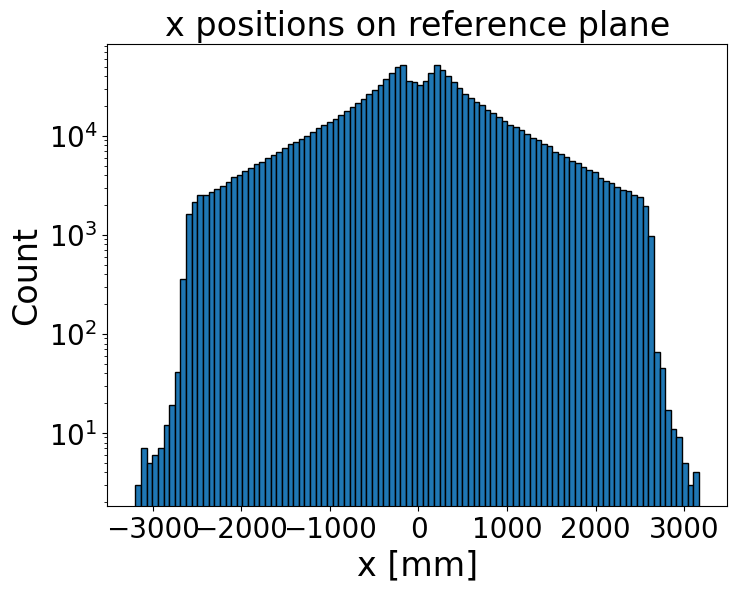

In [2]:
urax = df.loc[(df["x_ref"] > -3200) & (df["x_ref"] < 3200), "x_ref"].plot.hist(bins=100, logy=True,title='x positions on reference plane', figsize=(8,6), fontsize=20,edgecolor='black')
urax.set_xlabel('x [mm]', fontsize=24)
urax.set_ylabel('Count', fontsize=24)
urax.title.set_size(24)

In [3]:
from scipy.optimize import curve_fit
import numpy as np
def fitFastSigmoid(x, p0, p1, p2 ):
    return p0 + p1 * x / (1 + abs(x * p2) ) 

def sqrtSigmoid( x, p0, p1, p2 ):
    return p0 + p1 * x / np.sqrt( p2 + x**2 )

-1152.3191321144784 1144.5112688972854
BINS=900
shift=126.0
[ 4.50871394e+02  5.78026621e-01 -6.72848459e-04]
at -3000 = 2
at  0 = 576
at 3000 = 1151
at -3000 = 2.3960602381498575
at  0 = 576.8713937732111
at 3000 = 1151.3467273082724

-1152.3191321144784 1145.2265343593158
BINS=1000
shift=140.0
[5.00965281e+02 6.42244329e-01 6.72824292e-04]
at -3000 = 2
at  0 = 640
at 3000 = 1279
at -3000 = 2.6514499904290005
at  0 = 640.965281389201
at 3000 = 1279.279112787973



NBINS  nBinsReal  minBinWidth  maxBinWidth
0    900       1152     1.520524   411.883522
1   1000       1280     1.378500   406.784548

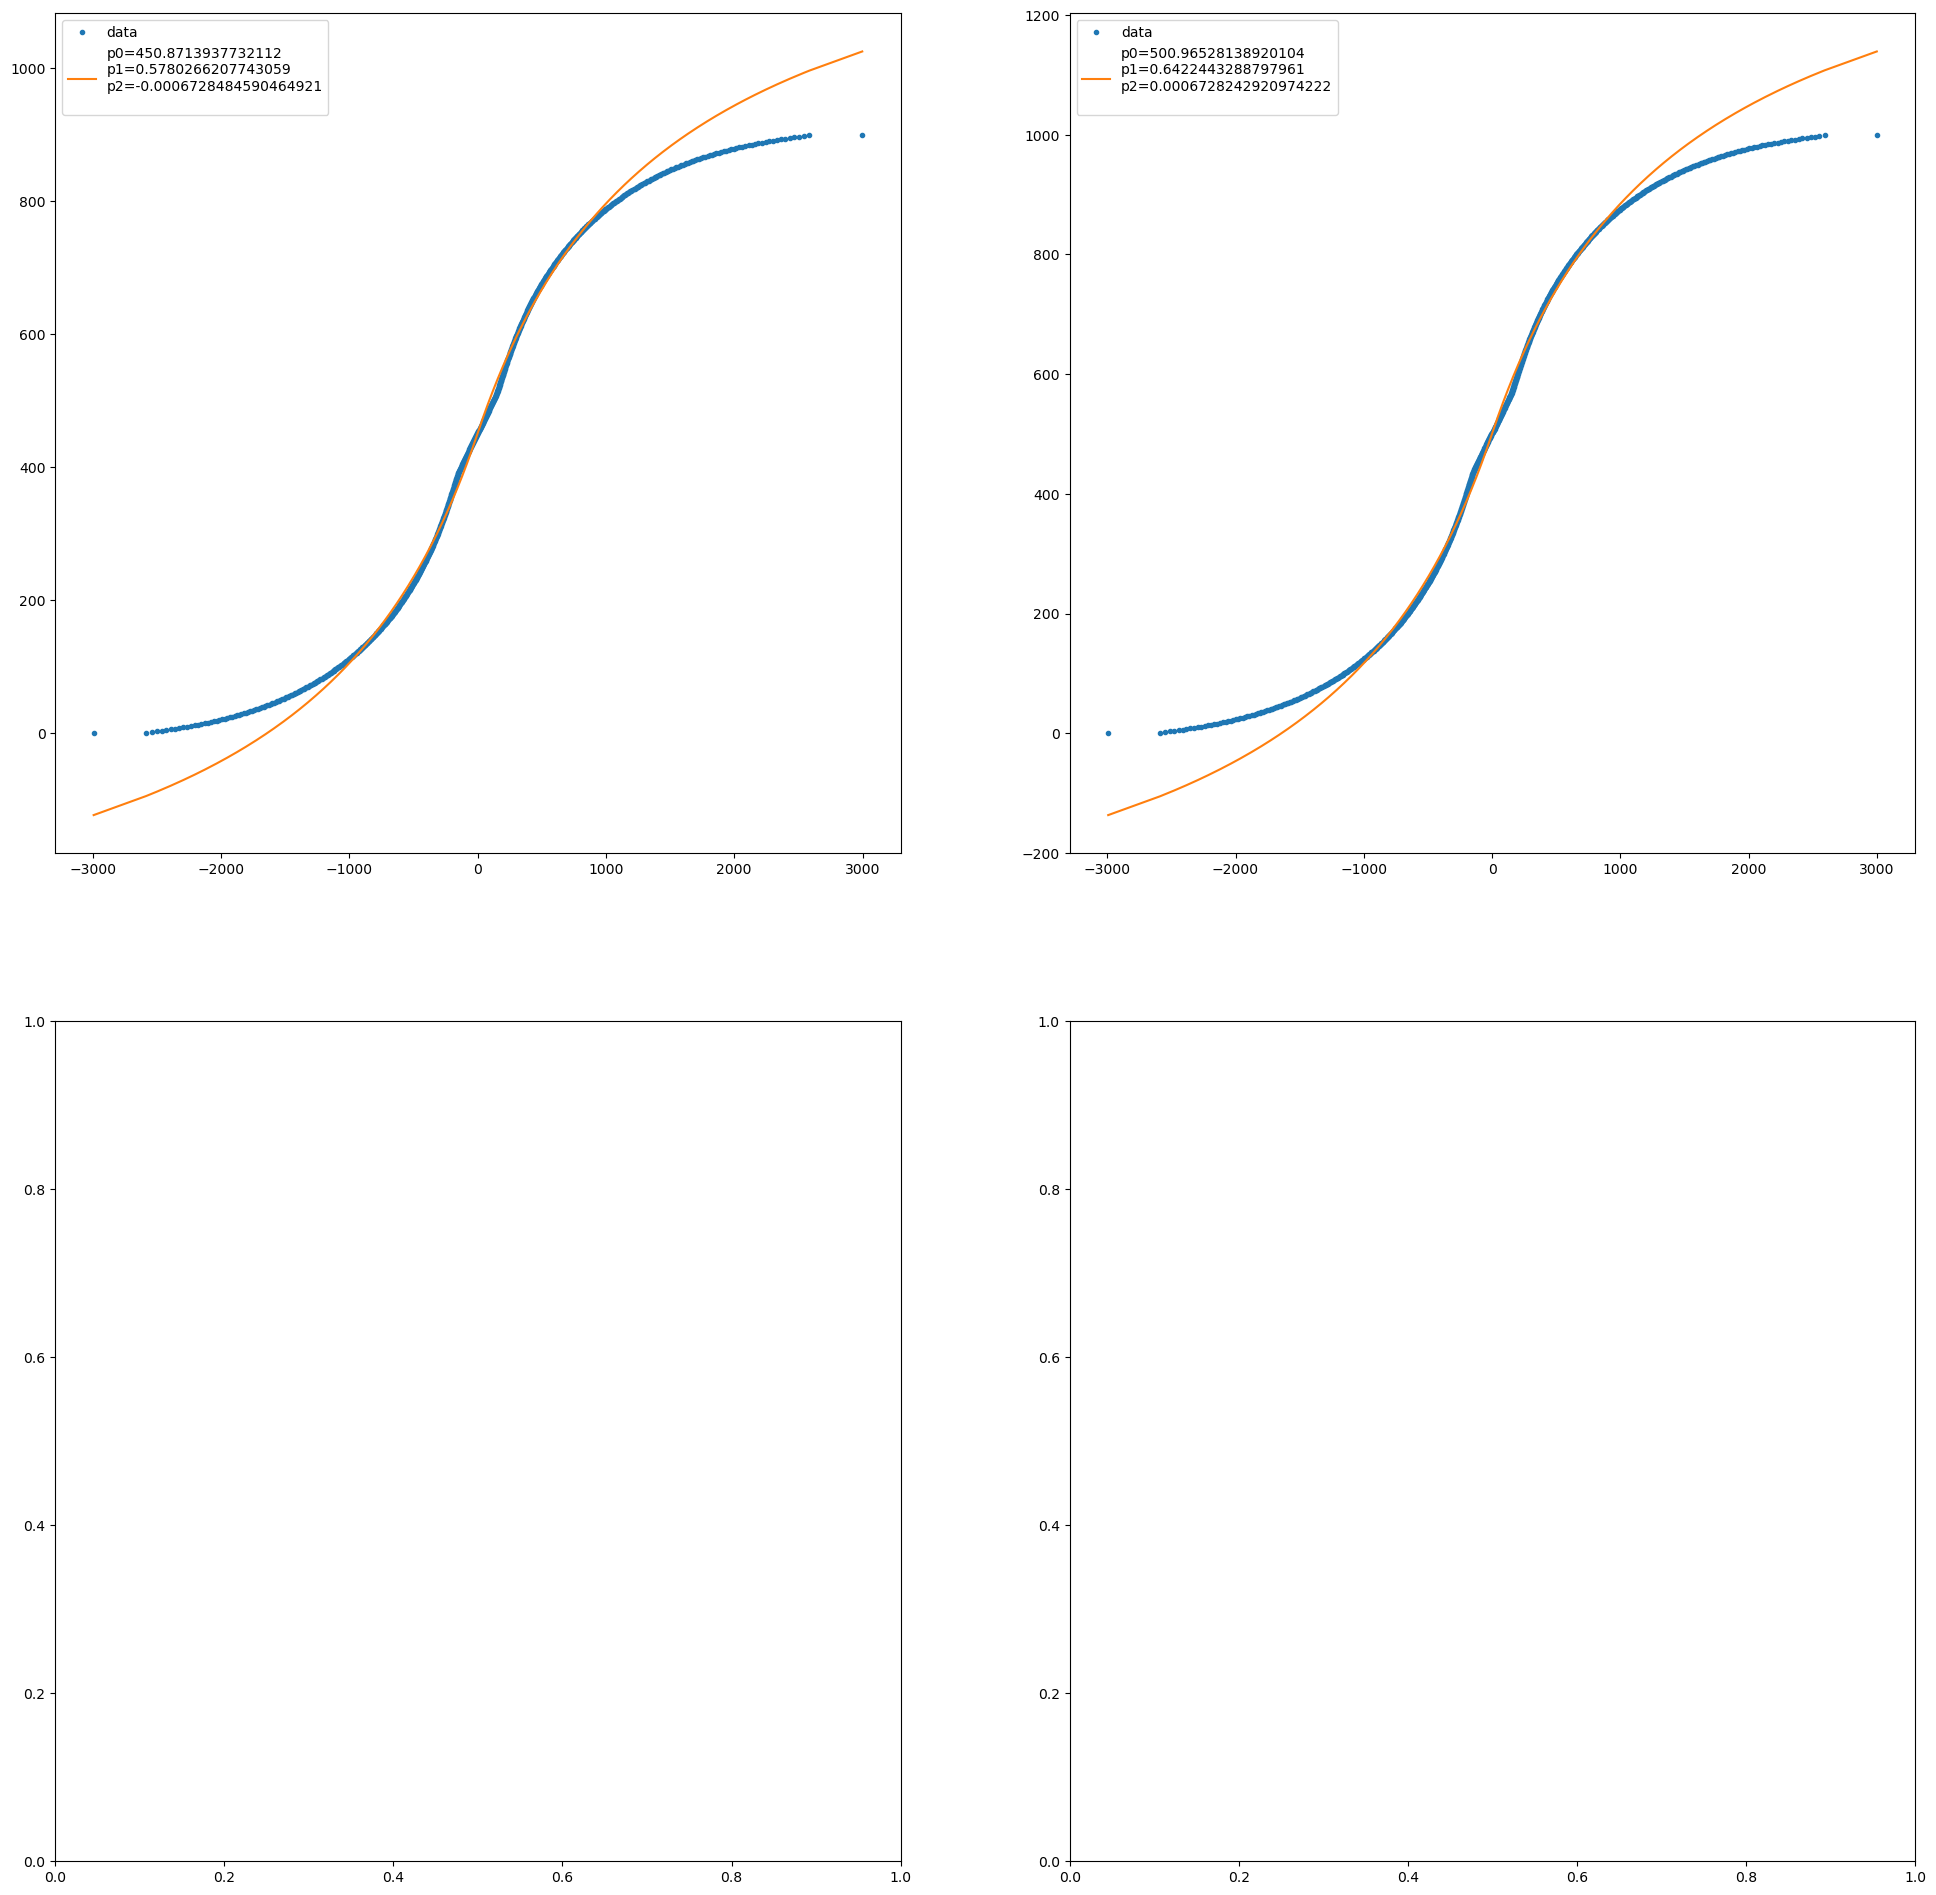

In [14]:
import pandas as pd
from math import ceil
selection = (df["x_ref"] > -3000) & (df["x_ref"] < 3000) 
data = df.loc[selection, "x_ref"]
#func = sqrtSigmoid
func = fitFastSigmoid
#NBINS=[800, 900, 1000, 1100]
NBINS=[900, 1000]
#SHIFTS = [48, 50, 53, 52]
SHIFTS=[126., 140.]
minBinWidths = []
maxBinWidths = []
nBinsReal = []
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 24))
for i, BINS in enumerate(NBINS):
    out, equal_bins = pd.qcut(data, q=BINS, retbins=True)
    binWidths = np.array([ abs(equal_bins[j] - equal_bins[j+1]) for j in range(len(equal_bins)-1)])
    minBinWidths.append( binWidths.min() )
    maxBinWidths.append( binWidths.max() )
    bin_numbering = np.arange(0, BINS+1)
    equalbins_center = equal_bins[int(BINS/10):int(9*BINS/10)]
    bin_numbering_center = bin_numbering[int(BINS/10):int(9*BINS/10)]
    print(equalbins_center[0], equalbins_center[-1])
    popt, pcov = curve_fit( func, xdata=equalbins_center, ydata=bin_numbering_center )
    if i<2:
        axes[0,i].plot(equal_bins, bin_numbering, '.', label='data')
        axes[0,i].plot(equal_bins, func(equal_bins, *popt), label=f'p0={popt[0]}\np1={popt[1]}\np2={popt[2]}\n')
        axes[0,i].legend()
    else:
        axes[1,i-2].plot(equal_bins, bin_numbering, '.', label='data')
        axes[1,i-2].plot(equal_bins, func(equal_bins, *popt), label=f'p0={popt[0]}\np1={popt[1]}\np2={popt[2]}\n')
        axes[1,i-2].legend()
    shift = SHIFTS[i]
    nBinsReal.append(ceil(func(3000, popt[0]+shift, popt[1], popt[2])))
    print(f'BINS={BINS}')
    print(f'shift={shift}')
    print(popt)
    print(f'at -3000 = {int(func(-3000., popt[0]+shift, popt[1], popt[2]))}')
    print(f'at  0 = {int(func(0., popt[0]+shift, popt[1], popt[2]))}')
    print(f'at 3000 = {int(func(3000., popt[0]+shift, popt[1], popt[2]))}')
    print(f'at -3000 = {func(-3000., popt[0]+shift, popt[1], popt[2])}')
    print(f'at  0 = {func(0., popt[0]+shift, popt[1], popt[2])}')
    print(f'at 3000 = {func(3000., popt[0]+shift, popt[1], popt[2])}')
    print()
binData = pd.DataFrame({'NBINS':NBINS, 'nBinsReal': nBinsReal,'minBinWidth':minBinWidths, 'maxBinWidth':maxBinWidths})
#ax = binData.plot(x='NBINS', y=['minBinWidth', 'maxBinWidth'], logy=True)
binData